# Data classification with SKLearn

## Data Generation

### Dependencies

In [1]:
import mpl_toolkits.mplot3d.axes3d as p3
#import pylab as pl
from sklearn.datasets import make_swiss_roll
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

### Rotation function

In [2]:
# create a rotz(angle) matrix
def rotation(angle, R = np.zeros((3,3))):
    R = np.array([[np.cos(angle), np.sin(angle), 0], [-np.sin(angle), np.cos(angle), 0], [0, 0, 1]])
    return R

### 3D plot function

In [3]:
# 3D scatter plot
def my_plot(X, col='blue', view1=10, view2=-150):
    fig = plt.figure()
    ax = p3.Axes3D(fig)
    ax.view_init(view1, view2)
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], s=10, c=col, marker='o')

### Generate a roll

In [4]:
# create a swiss-roll shaped cluster
def create_roll(n_samples=1000, noise=0.2, thickness=[20, 1, 50], offset=[0, 0, 0]):
    roll = make_swiss_roll(n_samples=n_samples, noise=noise)
    roll = roll[0]
    for j in range(3):
        for i in range(len(roll)):
            roll[i, j] *= thickness[j] / 20
            roll[i, j] += offset[j]
    return roll


## Create a 4-classes two-dimensional classification problem

In [5]:
data, targets = make_blobs(n_features=2, centers=[[1,1],[1,-1],[-1,-1],[-1,1]], n_samples=1000, cluster_std=[0.3,0.3,0.3,0.3], random_state=2)
data = data*abs(data)
data = np.matmul(data, rotation(1)[0:2,0:2])

### Plot data

(-4.0, 5.0, -6.0, 6.0)

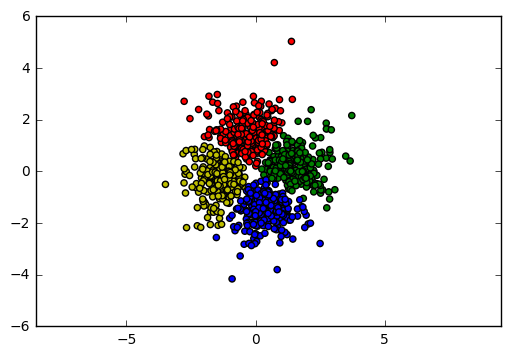

In [6]:
plt.scatter(data[:, 0], data[:, 1], marker='o', c= [('r', 'g', 'b', 'y')[t] for t in targets])
plt.axis('equal')

## Create rolls

In [7]:
roll1 = create_roll()
roll1 = np.matmul(roll1, rotation(0))
y_roll1 = ['#3D72C2'] * len(roll1)

roll2 = create_roll(offset=[0, 0, 6])
roll2 = np.matmul(roll2, rotation(np.pi/2))
y_roll2 = ['#DF8520'] * len(roll2)

### Plot rolls

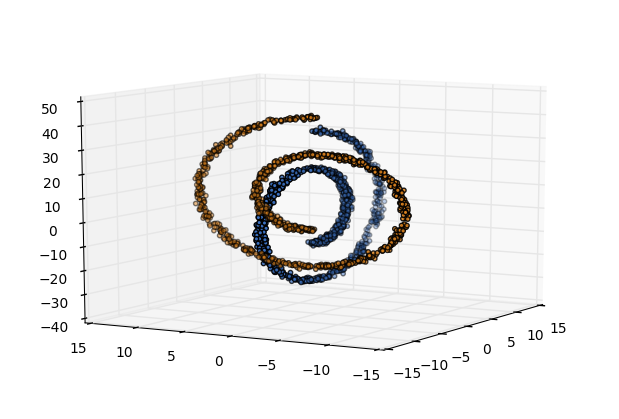

In [8]:
rolls = np.concatenate((roll1, roll2), axis=0)
y_rolls = np.concatenate((y_roll1, y_roll2), axis=0)
my_plot(rolls, y_rolls)

# Clustering

In [9]:
from sklearn.datasets import make_classification

In [10]:
# find the label that appears the most in a list of labels
def dominent_label(l):
    lab = -1
    nb = 0
    for k in set(l):
        if l.count(k) > nb:
            nb = l.count(k)
            lab = k
    return lab

# given the real labels and the estimated ones
# returns the estimated ones renamed to match with the real ones
def associate_labels(real_labels, found_labels):
    renamed = [0]*len(found_labels)
    for k in set(found_labels):
        d = dominent_label([real_labels[i] for i in range(len(real_labels)) if found_labels[i] == k])
        indices = [index for index, val in enumerate(found_labels) if k == val]
        for i in indices:
            renamed[i] = d
    return np.array(renamed)

In [11]:
# template for apllying a classification algorithm on the 4-class dataset, plot the result and check misclassification rate
def plot_classified_4classes(classified, targets, method_name='Classification'):

    plt.scatter(data[:, 0], data[:, 1], marker='o', c=classified.labels_)
    plt.axis('equal')
    plt.title(method_name + ' result')

    if len(set(classified.labels_)) == 4:
        renamed_labels = associate_labels(targets, classified.labels_)
        colored_renamed_labels = [('r', 'g', 'b', 'y')[l] for l in renamed_labels]
        error = [targets[i] != renamed_labels[i] for i in range(len(targets))]
        error_color = [('#00FF00', '#FF0000')[e] for e in error]

        plt.figure()
        plt.scatter(data[:, 0], data[:, 1], marker='o', c=colored_renamed_labels)
        plt.axis('equal')
        plt.title(method_name + ' corrected labels')

        plt.figure()
        plt.scatter(data[:, 0], data[:, 1], marker='o', c=error_color)
        plt.axis('equal')
        plt.title('Misclassified sample')

        N = len(error)
        misclass = error.count(1)

        print('Misclassified : ' + str(100 * misclass / N) + '% (' + str(misclass) + ' / ' + str(N) + ')')
    else:
        print('The number of classes found is different from 4 (' + str(len(set(classified.labels_))) + '), can not compute misclassification rate.')

In [12]:
# template for apllying a classification algorithm on the swiss-rolls dataset, plot the result and check misclassification rate
def plot_classified_swiss_rolls(classified, y_rolls, method_name):
    renamed_labels = associate_labels(y_rolls, classified.labels_)  
    error = [y_rolls[i] != renamed_labels[i] for i in range(len(y_rolls))]
    error_color = [('#00FF00', '#FF0000')[e] for e in error]

    my_plot(rolls, classified.labels_)
    plt.title(method_name + ' result')
    if len(set(classified.labels_)) == 2:
        my_plot(rolls, renamed_labels)
        plt.title(method_name + ' corrected labels')
        my_plot(rolls, error_color)
        plt.title('Misclassified samples')

        N = len(error)
        misclass = error.count(1)

        print('Misclassified : ' + str(100 * misclass / N) + '% (' + str(misclass) + ' / ' + str(N) + ')')
    else:
        print('The number of classes found is different from 2 (' + str(len(set(classified.labels_))) + '), can not compute misclassification rate.')

## Kmean

In [13]:
from sklearn.cluster import KMeans
method_name = 'K-Means'

### 4-classes

Misclassified : 0.2% (2 / 1000)


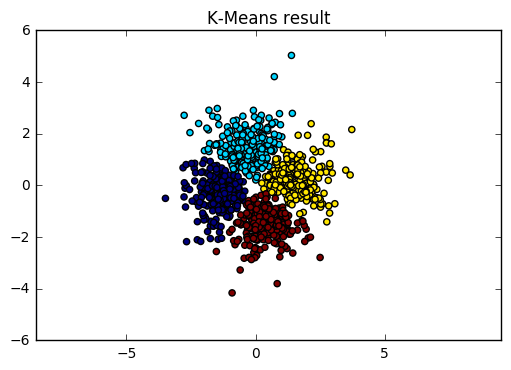

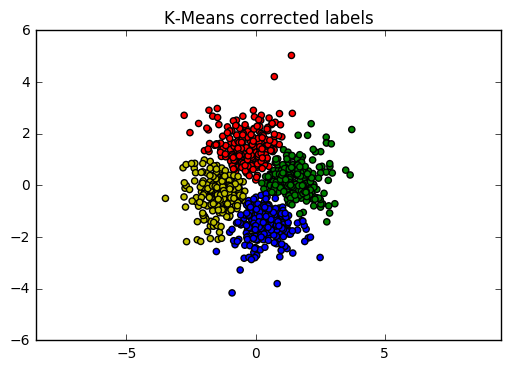

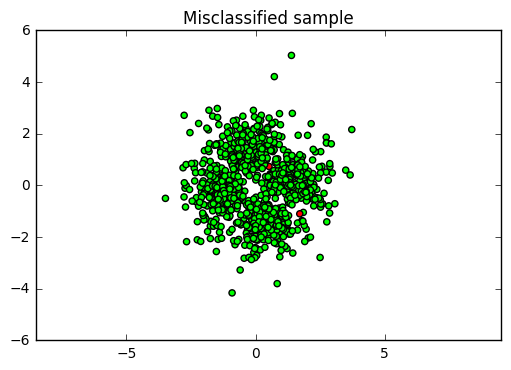

In [14]:
classified = KMeans(n_clusters=4).fit(data)
plot_classified_4classes(classified, targets, method_name)

### Swiss rolls

Misclassified : 46.35% (927 / 2000)


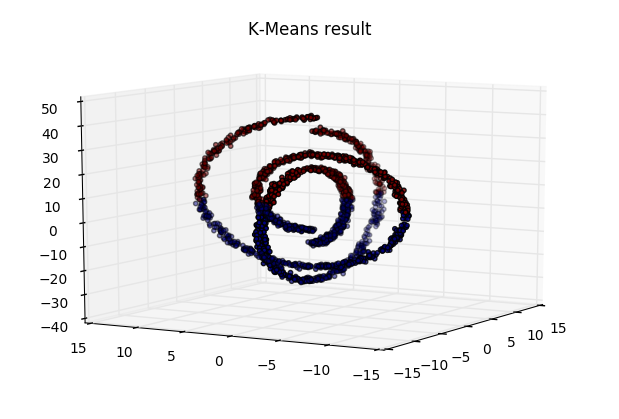

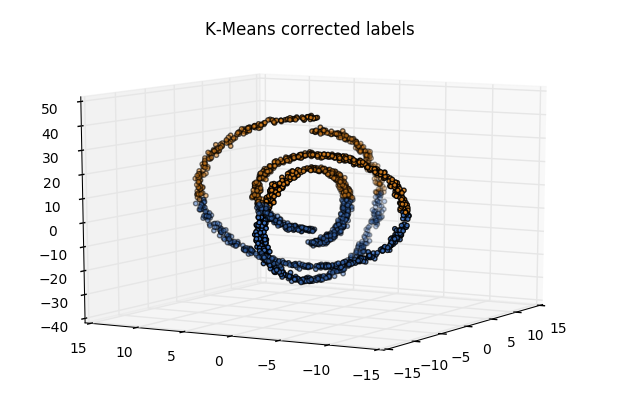

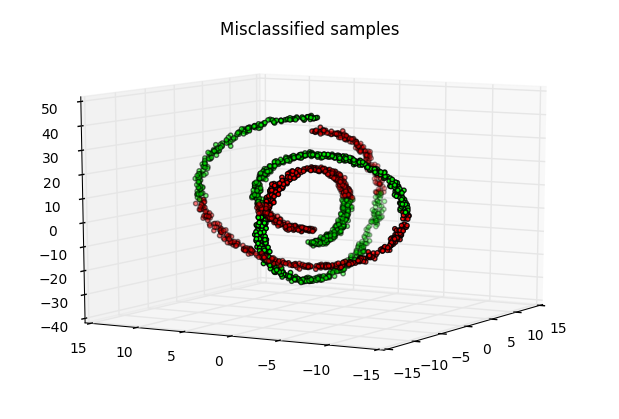

In [15]:
classified = KMeans(n_clusters=2).fit(rolls)
plot_classified_swiss_rolls(classified, y_rolls, method_name)

### Affinity propagation

In [16]:
from sklearn.cluster import AffinityPropagation
method_name = 'Affinity Propagation'

### 4-classes

The number of classes found is different from 4 (32), can not compute misclassification rate.


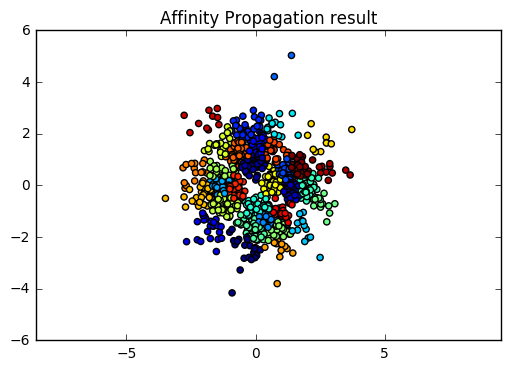

In [45]:
classified = AffinityPropagation().fit(data)
plot_classified_4classes(classified, targets, method_name)

### Swiss rolls

The number of classes found is different from 2 (1074), can not compute misclassification rate.


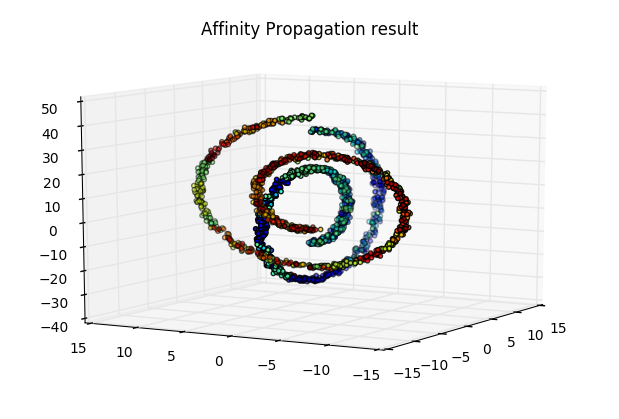

In [18]:
classified = AffinityPropagation().fit(rolls)
plot_classified_swiss_rolls(classified, y_rolls, method_name)

## Mean Shift

In [46]:
from sklearn.cluster import MeanShift
method_name = 'Mean Shift'

### 4-classes

The number of classes found is different from 4 (2), can not compute misclassification rate.


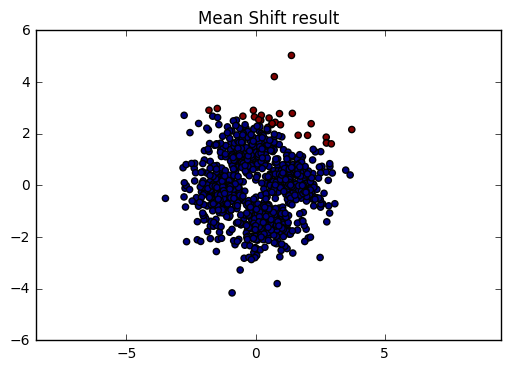

In [20]:
classified = MeanShift().fit(data)
plot_classified_4classes(classified, targets, method_name)

### Swiss rolls

Misclassified : 45.95% (919 / 2000)


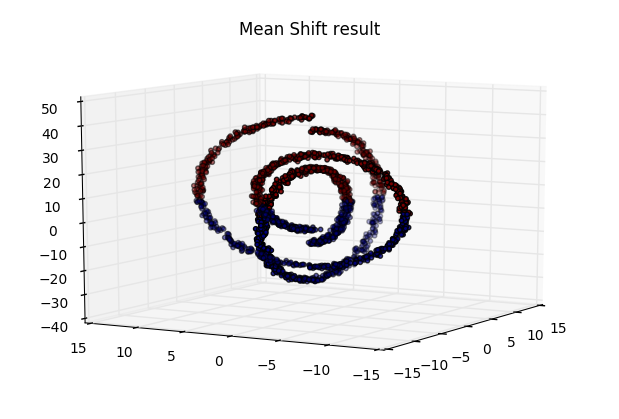

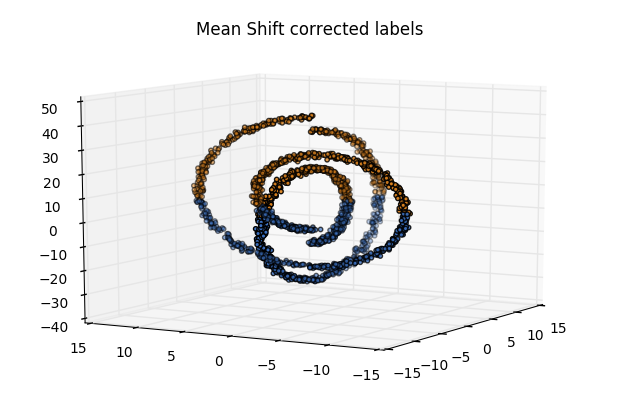

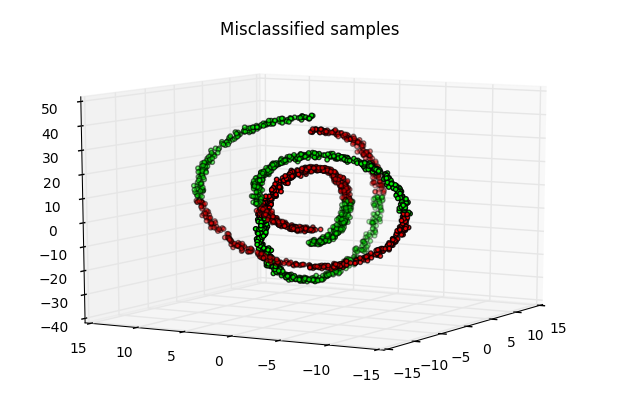

In [21]:
classified = MeanShift().fit(rolls)
plot_classified_swiss_rolls(classified, y_rolls, method_name)

## Spectral Clustering

In [22]:
from sklearn.cluster import SpectralClustering
method_name = 'Spectral Clustering'

### 4-classes

Misclassified : 0.9% (9 / 1000)


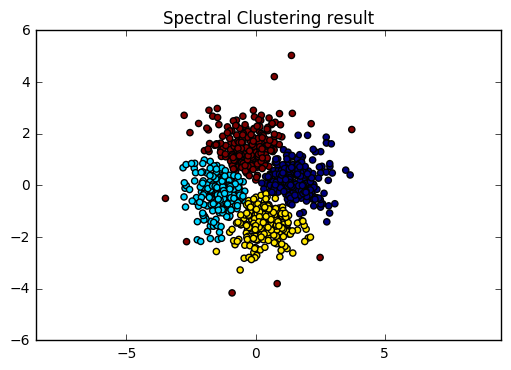

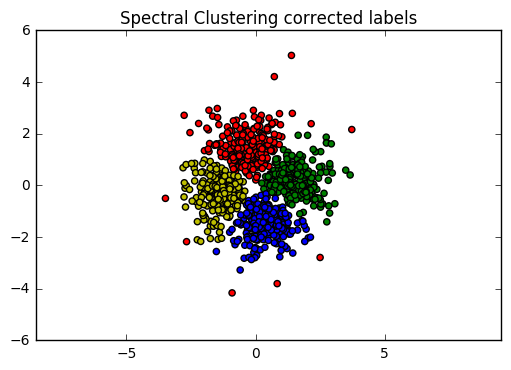

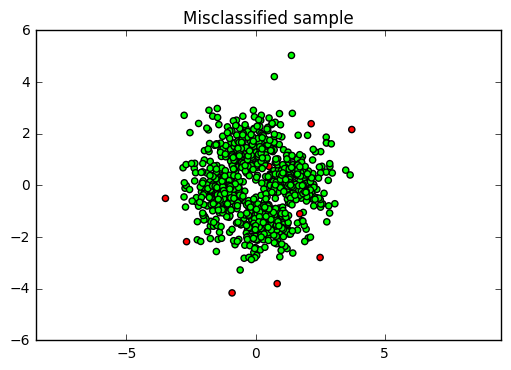

In [23]:
classified = SpectralClustering(n_clusters=4, gamma=1.5).fit(data)
plot_classified_4classes(classified, targets, method_name)

### Swiss rolls

Misclassified : 0.0% (0 / 2000)


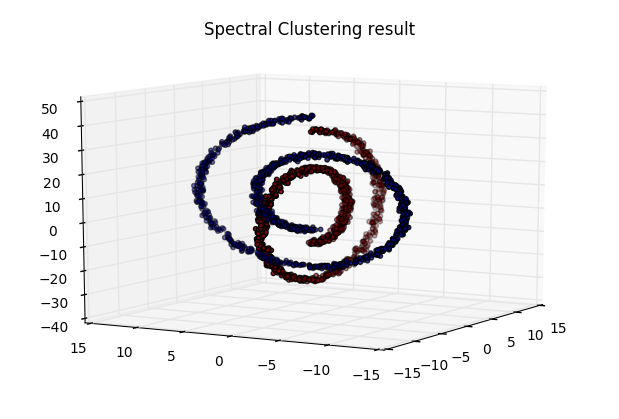

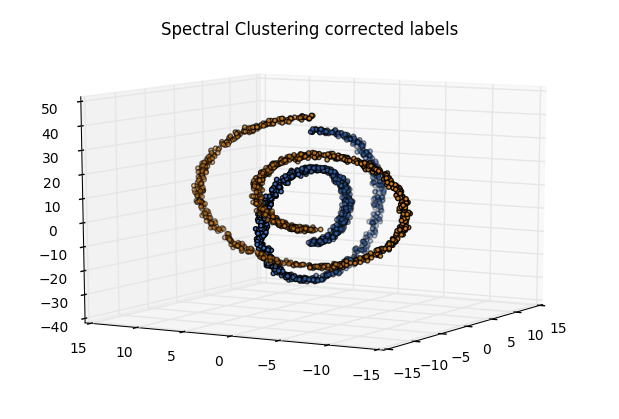

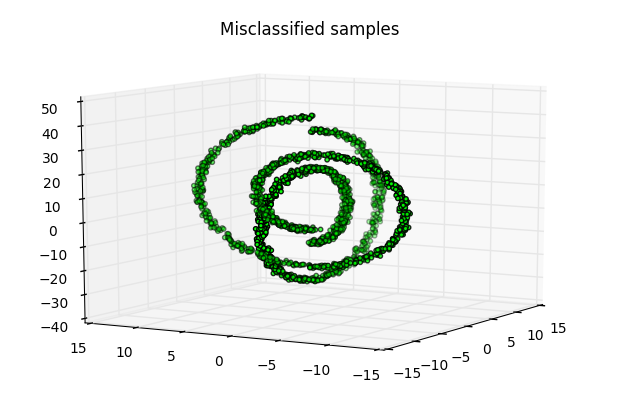

In [24]:
classified = SpectralClustering(n_clusters=2).fit(rolls)
plot_classified_swiss_rolls(classified, y_rolls, method_name)

## Agglomerative Clustering

In [25]:
from sklearn.cluster import AgglomerativeClustering
method_name = 'Agglomerative Clustering'

### 4-classes

Misclassified : 3.2% (32 / 1000)


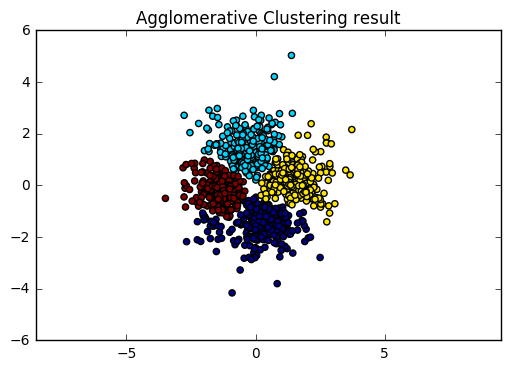

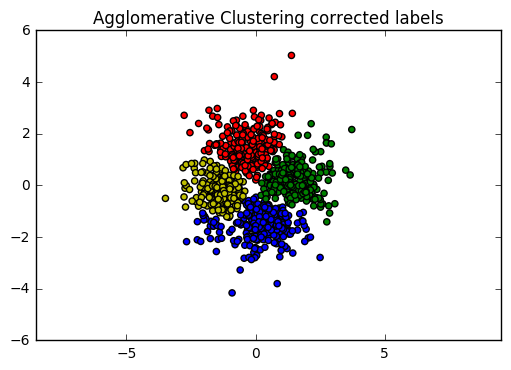

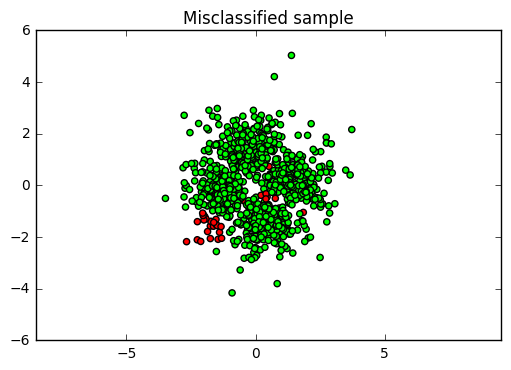

In [26]:
classified = AgglomerativeClustering(n_clusters=4).fit(data)
plot_classified_4classes(classified, targets, method_name)

### Swiss rolls

Misclassified : 40.4% (808 / 2000)


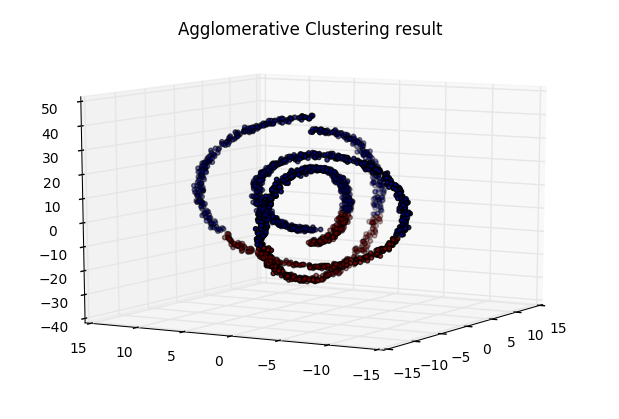

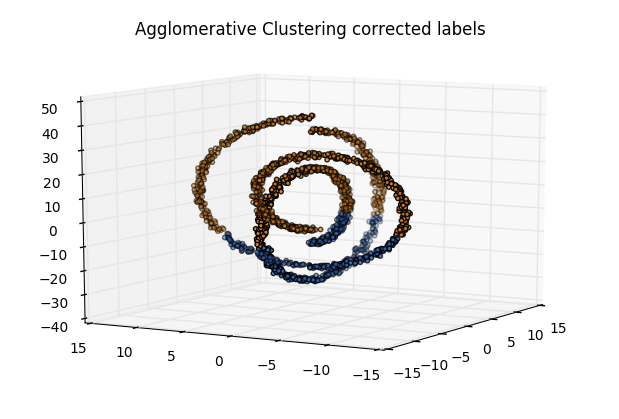

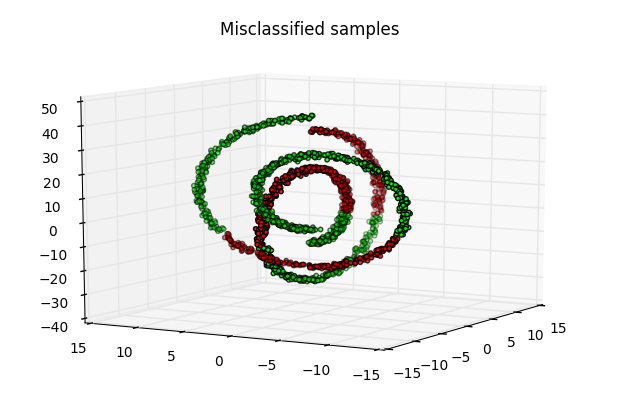

In [27]:
classified = AgglomerativeClustering(n_clusters=2).fit(rolls)
plot_classified_swiss_rolls(classified, y_rolls, method_name)

## DBscan

In [28]:
from sklearn.cluster import DBSCAN
method_name = 'DBscan'

### 4-classes

The number of classes found is different from 4 (12), can not compute misclassification rate.


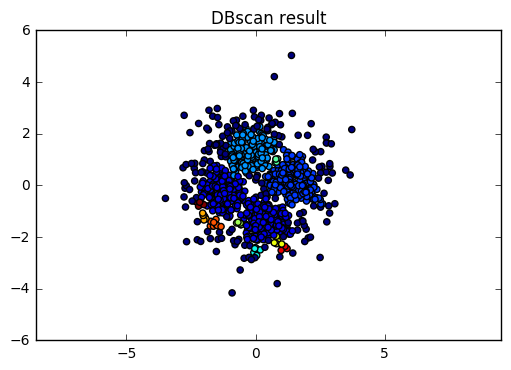

In [29]:
classified = DBSCAN(eps=0.2).fit(data)
plot_classified_4classes(classified, targets, method_name)

### Swiss rolls

Misclassified : 0.0% (0 / 2000)


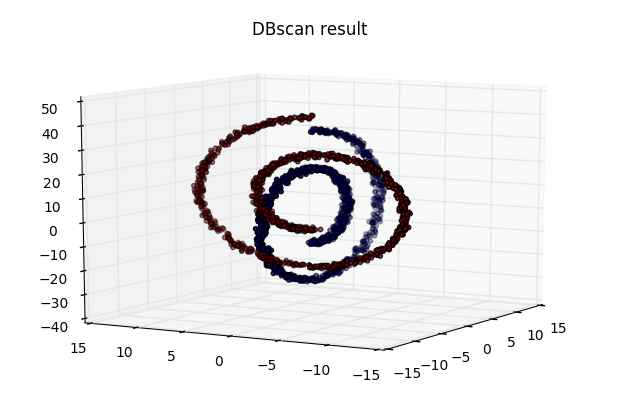

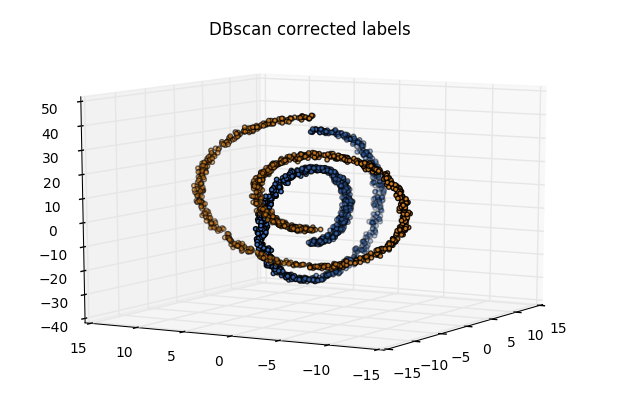

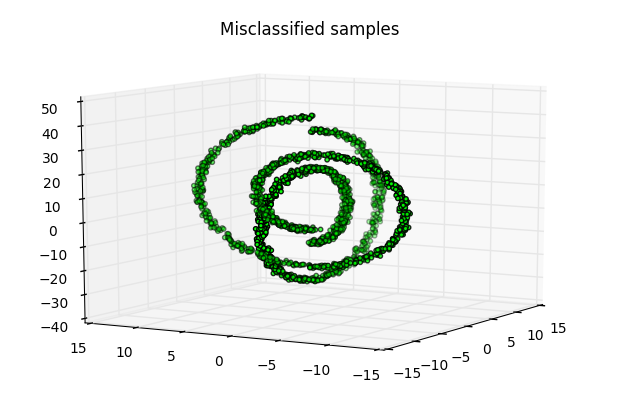

In [30]:
classified = DBSCAN(eps=2).fit(rolls)
plot_classified_swiss_rolls(classified, y_rolls, method_name)

## Birch

In [31]:
from sklearn.cluster import Birch
method_name = 'Birch'

### 4-classes

Misclassified : 13.2% (132 / 1000)


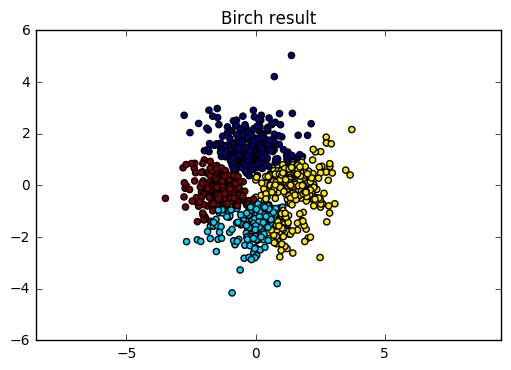

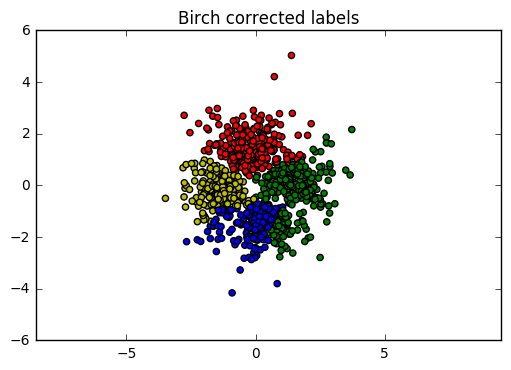

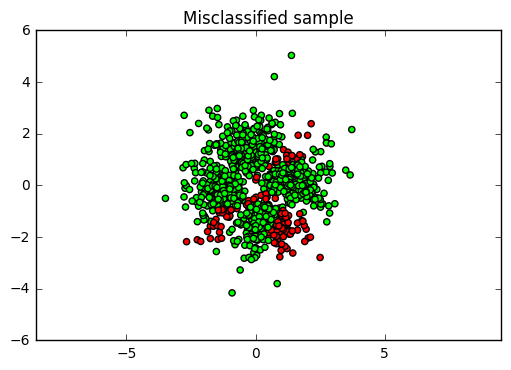

In [32]:
classified = Birch(n_clusters=4).fit(data)
plot_classified_4classes(classified, targets, method_name)

### Swiss rolls

Misclassified : 48.6% (972 / 2000)


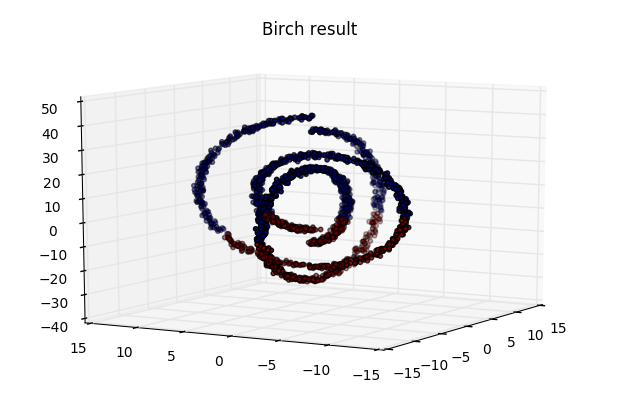

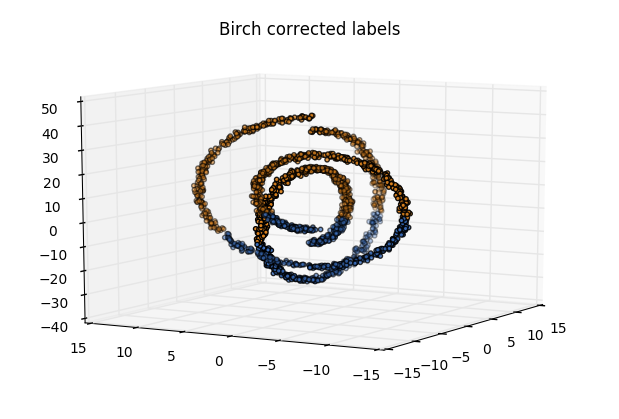

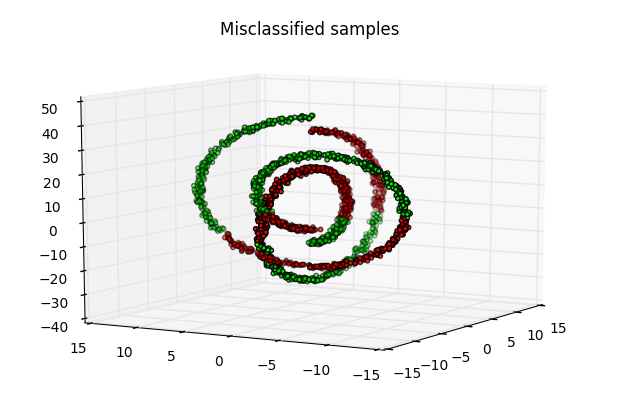

In [33]:
classified = Birch(n_clusters=2).fit(rolls)
plot_classified_swiss_rolls(classified, y_rolls, method_name)

# Miscassification rates for these datasets

<table style="border-collapse:collapse;border-spacing:0;border-color:#aabcfe"><tr><th style="font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#aabcfe;color:#039;background-color:#b9c9fe;text-align:center;vertical-align:top">Method \ Dataset<br></th><th style="font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#aabcfe;color:#039;background-color:#b9c9fe;text-align:center;vertical-align:top">4-clusters</th><th style="font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#aabcfe;color:#039;background-color:#b9c9fe;text-align:center;vertical-align:top">Swiss Roll </th><th style="font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#aabcfe;color:#039;background-color:#b9c9fe;text-align:center;vertical-align:top">Comment</th></tr><tr><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#aabcfe;color:#669;background-color:#e8edff;text-align:center;vertical-align:top">KMean</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#aabcfe;color:#669;background-color:#e8edff;text-align:center;vertical-align:top">0.2%</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#aabcfe;color:#669;background-color:#e8edff;text-align:center;vertical-align:top">43.95%</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#aabcfe;color:#669;background-color:#e8edff;text-align:center;vertical-align:top">Works well to classify linearly separable clusters (only). - Best for the 4-classes problem.</td></tr><tr><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#aabcfe;color:#669;background-color:#e8edff;text-align:center;vertical-align:top">Affinity Propagation</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#aabcfe;color:#669;background-color:#e8edff;text-align:center;vertical-align:top">nan</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#aabcfe;color:#669;background-color:#e8edff;text-align:center;vertical-align:top">nan</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#aabcfe;color:#669;background-color:#e8edff;text-align:center;vertical-align:top">Tends to recognize too many clusters</td></tr><tr><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#aabcfe;color:#669;background-color:#e8edff;text-align:center;vertical-align:top">Mean SHift</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#aabcfe;color:#669;background-color:#e8edff;text-align:center;vertical-align:top">nan</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#aabcfe;color:#669;background-color:#e8edff;text-align:center;vertical-align:top">43.8%</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#aabcfe;color:#669;background-color:#e8edff;text-align:center;vertical-align:top">Recognize only 2 clusters out of 4. Do not succeed to classify non-linearly separable sets.</td></tr><tr><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#aabcfe;color:#669;background-color:#e8edff;text-align:center;vertical-align:top">Spectral Clustering</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#aabcfe;color:#669;background-color:#e8edff;text-align:center;vertical-align:top">0.9%</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#aabcfe;color:#669;background-color:#e8edff;text-align:center;vertical-align:top">0%</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#aabcfe;color:#669;background-color:#e8edff;text-align:center;vertical-align:top">Works well on dense clusters, but miss some far-away samples.  - Best for this Swiss rolls set.</td></tr><tr><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#aabcfe;color:#669;background-color:#e8edff;text-align:center;vertical-align:top">Agglomerative Clustering</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#aabcfe;color:#669;background-color:#e8edff;text-align:center;vertical-align:top">3.2%</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#aabcfe;color:#669;background-color:#e8edff;text-align:center;vertical-align:top">39.65%</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#aabcfe;color:#669;background-color:#e8edff;text-align:center;vertical-align:top">Misclassify some linearly separable clusters' samples. Do not perform well on non-linearly separable sets.</td></tr><tr><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#aabcfe;color:#669;background-color:#e8edff;text-align:center;vertical-align:top">DBscan</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#aabcfe;color:#669;background-color:#e8edff;text-align:center;vertical-align:top">nan</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#aabcfe;color:#669;background-color:#e8edff;text-align:center;vertical-align:top">0%</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#aabcfe;color:#669;background-color:#e8edff;text-align:center;vertical-align:top">Recognize too many classes for the first set but classify correctly the second. - Best for this Swiss rolls set.</td></tr><tr><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#aabcfe;color:#669;background-color:#e8edff;text-align:center;vertical-align:top">Birch</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#aabcfe;color:#669;background-color:#e8edff;text-align:center;vertical-align:top">13.2%</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#aabcfe;color:#669;background-color:#e8edff;text-align:center;vertical-align:top">42.9%</td><td style="font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:#aabcfe;color:#669;background-color:#e8edff;text-align:center;vertical-align:top">Misclassify some linearly separable clusters' samples. Do not perform well on non-linearly separable sets.</td></tr></table>